In [31]:
import os
import json
import pandas as pd

results_folder = '.probing_reports/'
results_files = os.listdir(results_folder)

# Load all results into a single dataframe
results_dict = {
    'model': [],
    'task': [],
    'layer': [],
    'accuracy': [],
    'f1': [],
    'uniform_codelength': [],
    'online_codelength': [],
    'compression_ratio': [],
}

# Dictionary to map task names to human-readable names
task_dict = {
    'sentence_length': 'SentLen',
    'word_content': 'WC',
    'tree_depth': 'TreeDepth',
    'top_constituents': 'TopConst',
    'bigram_shift': 'BiShift',
    'subj_number': 'SubjNum',
    'obj_number': 'ObjNum',
    'odd_man_out': 'SOMO',
    'coordination_inversion': 'CoordInv',
}

# for file in results_files:
for file in results_files:
    with open(results_folder + file, 'r') as f:
        filename = file.split('-')
        task, model, layer = filename[0], filename[1], filename[-2]

        task = task_dict[task]

        data = json.load(f)
        accuracy, macro_f1, weighted_f1 = data['online_coding_results'][-1]['classification_report'].values()
        uniform_codelength = data['uniform_codelength']
        online_codelength = data['online_codelength']
        compression_ratio = data['compression_ratio']

        # Check if layer is a number
        if layer.isnumeric():
            layer = int(layer)
        else:
            layer = 0

        # Turn accuracy and f1 scores into percentages
        accuracy *= 100
        macro_f1 *= 100

        results_dict['model'].append(model)
        results_dict['task'].append(task)
        results_dict['layer'].append(layer)
        results_dict['accuracy'].append(accuracy)
        results_dict['f1'].append(macro_f1)
        results_dict['uniform_codelength'].append(uniform_codelength)
        results_dict['online_codelength'].append(online_codelength)
        results_dict['compression_ratio'].append(compression_ratio)

results = pd.DataFrame(results_dict)

## Model feature classification

In [32]:
# Get values only from the last layer of each model
results_classification = results.query("(model == 'bilstm') | (model != 'bilstm' & layer == 12)" )

# Rename model names
results_classification['model'] = results_classification['model'].replace({'bilstm': "BiLSTM", 'mpnet': "MPNet"})

results_classification

/tmp/ipykernel_378682/4118038852.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_classification['model'] = results_classification['model'].replace({'bilstm': "BiLSTM", 'mpnet': "MPNet"})


,model,task,layer,accuracy,f1,uniform_codelength,online_codelength,compression_ratio
2,BiLSTM,TopConst,0,78.881445,78.443584,303334.523340,64517.373365,4.70
3,MPNet,SentLen,12,64.875984,65.020502,225946.402263,81497.779452,2.77
5,BiLSTM,ObjNum,0,82.125665,82.122966,80124.000000,27938.112959,2.87
7,MPNet,SubjNum,12,80.697018,80.682682,82010.000000,32259.946088,2.54
43,MiniLM,TopConst,12,57.398777,56.800007,303334.523340,117621.983573,2.58
...,...,...,...,...,...,...,...,...
1185,BiLSTM,SentLen,0,77.359821,77.126854,225946.402263,54144.581475,4.17
1189,BiLSTM,WC,0,85.658548,85.694395,835810.396386,144412.347866,5.79
1195,MiniLM,BiShift,12,73.370000,73.368165,100000.000000,54699.411650,1.83
1207,MPNet,TreeDepth,12,31.380753,33.436307,239579.669048,144762.621279,1.65


In [37]:
table = results_classification.pivot_table(index='task', columns='model', values='accuracy', aggfunc='mean').round(1)

# Sort rows by task order
task_order = list(task_dict.values())
table.reindex(task_order)

model,BiLSTM,MPNet,MiniLM
task,,,
SentLen,77.5,64.5,61.6
WC,85.2,64.1,64.4
TreeDepth,39.5,30.9,30.5
TopConst,78.7,56.9,56.9
BiShift,61.6,79.2,73.6
SubjNum,85.5,81.2,79.5
ObjNum,82.3,78.9,78.8
SOMO,52.7,61.7,57.4
CoordInv,69.1,62.2,56.3


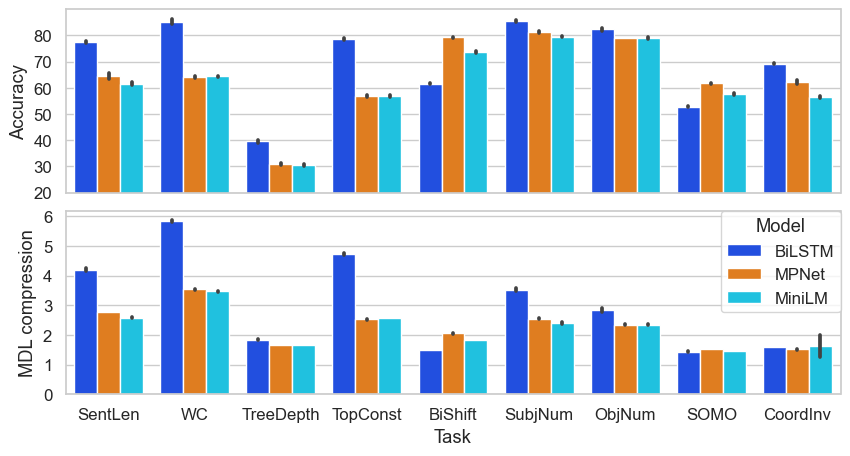

In [64]:
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np

# Increase font size
sns.set(font_scale=1.1)

# sns remove background
sns.set_style("whitegrid", {'axes.grid' : False})

task_order = list(task_dict.values())

palette = sns.color_palette("bright")
palette = [palette[0], palette[1], palette[-1]]
fix, axes = plt.subplots(2, 1, figsize=(10, 5), sharex=True)

ax = axes[0]
# Plot accuracy where y-axis is the accuracy, x-axis is task and hue is model
sns.barplot(data=results_classification, x='task', y='accuracy', hue='model',
            width=.8, ax=ax, order=task_order, palette=palette, errorbar="sd")

# Remove legend
ax.legend().remove()

# Remove x label
ax.set_xlabel('')
ax.set_ylabel('Accuracy')
ax.grid(axis='y')

# Make y axis have more ticks from 0-1 with 0.1
ax.set_yticks(np.arange(20, 90, 10))

# Set y limit
ax.set_ylim(20, 90)

ax = axes[1]
# Plot accuracy where y-axis is the accuracy, x-axis is task and hue is model
sns.barplot(data=results_classification, x='task', y='compression_ratio', hue='model',
            width=.8, ax=ax, order=task_order, palette=palette, errorbar="sd")

# Rename y label
ax.set_ylabel('MDL compression')
ax.set_xlabel('Task')
ax.grid(axis='y')

# y axis ticks
ax.set_yticks(np.arange(0, 7, 1))

# put legend outside the figure
ax.legend(bbox_to_anchor=(1, 1),borderaxespad=0, title='Model')

plt.subplots_adjust(hspace=0.1)

plt.savefig('results/classification_results.png', bbox_inches='tight')
plt.savefig('results/classification_results.pdf', bbox_inches='tight', format='pdf', dpi=150)
plt.show()


## Layer results

In [79]:
sns.set(font_scale=1.7)
sns.set_style("whitegrid", {'axes.grid' : False})

fix, axes = plt.subplots(9, 1, figsize=(8,24), sharex=True)

palette = sns.color_palette("bright")
palette = [palette[1], palette[-1]]

results_classification = results.query("(model != 'bilstm')")
results_classification['model'] = results_classification['model'].replace({'mpnet': "MPNet"})


for i, task in enumerate(task_order):
    subset = results_classification.query(f"task == '{task}'")

    ax = axes[i]

    sns.lineplot(data=subset, x='layer', y='compression_ratio', hue='model', hue_order=['MPNet', 'MiniLM'], ax=ax, palette=palette, marker='s', errorbar=None, linewidth=2.5)

    ax.grid(axis='x')

    ax.set_xticks(np.arange(0, 13, 1)) # Set x axis ticks
    ax.set_yticks(np.linspace(np.round(ax.get_ybound()[0], 2), np.round(ax.get_ybound()[1], 2), 4))
    ax.set_ylabel(task) # Rename y label
    ax.set_xlabel('Layers')

    # Get the current locations and labels
    locs, labels = ax.get_yticks(), ax.get_yticklabels()

    # Set new labels to the current locations
    new_labels = ['{:0.1f}'.format(loc) for loc in locs]
    ax.set_yticklabels(new_labels)

    # If not last plot, remove legend
    if i != len(task_order) - 1:
        ax.get_legend().remove()
    else:
        ax.legend(title='Model')

plt.subplots_adjust(hspace=0.2)

plt.savefig('results/layer_compression.png', bbox_inches='tight')
plt.savefig('results/layer_compression.pdf', bbox_inches='tight', format='pdf', dpi=200)

plt.show()

/tmp/ipykernel_378682/1028440280.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_classification['model'] = results_classification['model'].replace({'mpnet': "MPNet"})
